# Cointegration Mean Reversion Strategy

In this notebook we explore the idea of cointegrated mean reverting strategy. The idea is that highly correlated stocks will have a spread that tends to mean-revert which we can profit from

# Order Dependence of CADF Test results

This notebook demonstrates with an example of Gold Miners ETF (GDX) and US Oil ETF (USO) that the results of CADF Test depend on which price series is picked as y (dependent variable) vs. x (independent variable).

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

start = (datetime.now() + timedelta(-(5 * 365))).strftime("%Y-%m-%d")
end = (datetime.now() + timedelta(1)).strftime("%Y-%m-%d")
interval = '1d'

In [2]:
data = yf.download(['GLD','GDX'], start, end, interval)

[*********************100%***********************]  2 of 2 completed


<AxesSubplot:xlabel='Date'>

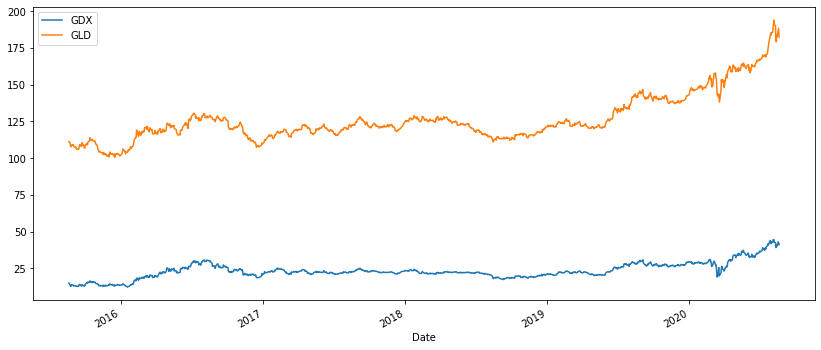

In [3]:
data['Adj Close'].plot(figsize=(14,6))

## Hedge ratio

The Hedge ratio is calculated using linear regression. Only first year of GLD and GDX data is used to calculate the Hedge Ratio to avoid look ahead bias.

Hedge Ratio is 5.60


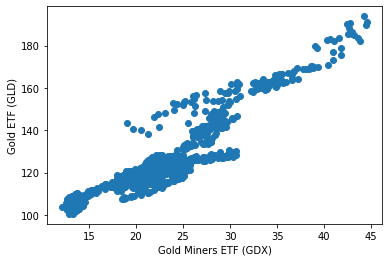

In [4]:
model = sm.OLS(data['Adj Close'].GLD.iloc[:252], data['Adj Close'].GDX.iloc[:252])
model = model.fit() 
print('Hedge Ratio is %.2f'% model.params[0])

# Plot the scatter graph for full data of GLD and GDX 
plt.scatter(data['Adj Close'].GDX, data['Adj Close'].GLD)
plt.xlabel("Gold Miners ETF (GDX)")
plt.ylabel("Gold ETF (GLD)")
plt.show()

## Calculate spread using hedge ratio 

In [5]:
df = pd.concat([data['Adj Close'], pd.DataFrame(data['Adj Close'].GLD - model.params[0] * data['Adj Close'].GDX, columns=['spread'])], axis=1)

<AxesSubplot:xlabel='Date'>

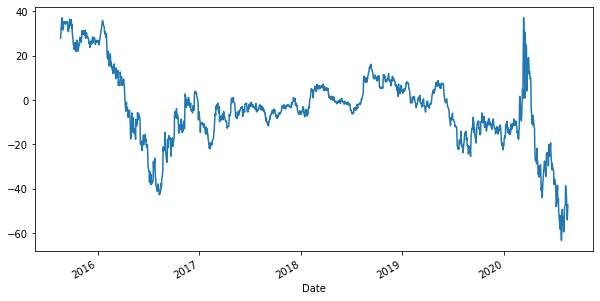

In [6]:
df.spread.plot(figsize=(10,5))

In [7]:
resultsAdf = ts.adfuller(df['spread'])
resultsAdf[0]

-2.1660422477600427

This test shows that it is negative but close to the rejection zone. Let's assume it's stationary.

### Compute moving average, moving standard deviation, upper band and lower band

In [9]:
lookback = 5

# Moving Average and Moving Standard Deviation
df['moving_average'] = df.spread.rolling(lookback).mean()
df['moving_std_dev'] = df.spread.rolling(lookback).std()

# Upper band and lower band
df['upper_band'] = df.moving_average + 0.5 * df.moving_std_dev
df['lower_band'] = df.moving_average - 0.5 * df.moving_std_dev
df.head(7)

,GDX,GLD,spread,moving_average,moving_std_dev,upper_band,lower_band
Date,,,,,,,
2015-08-21,14.908216,111.129997,27.695732,NaN,NaN,NaN,NaN
2015-08-24,13.687658,110.529999,33.926623,NaN,NaN,NaN,NaN
2015-08-25,13.242060,109.160004,35.050433,NaN,NaN,NaN,NaN
2015-08-26,12.631783,107.669998,36.975861,NaN,NaN,NaN,NaN
2015-08-27,13.358303,107.730003,32.969873,33.323704,3.481473,35.064441,31.582968
2015-08-28,13.803904,108.699997,31.446051,34.073768,2.092914,35.120225,33.027311
2015-08-31,13.668286,108.820000,32.325039,33.753452,2.238556,34.872730,32.634173


## Entry and exit conditions

Long_entry is set to True value whenever the spread falls below the lower band and False otherwise. 
Long_exit is set to True value whenever the spread mean-reverts to the current moving average (spread >= moving average) and False otherwise.

Similarly, short entry is set to True value whenever the spread rises above the upper band and False otherwise. The short exit is set to True value whenever the spread mean-reverts to the current moving average (prices <= moving average) and False otherwise.

In [10]:
# Long
df['long_entry'] = df.spread < df.lower_band
df['long_exit'] = df.spread >= df.moving_average

# Short
df['short_entry'] = df.spread > df.upper_band
df['short_exit'] = df.spread <= df.moving_average

df.head(7)

,GDX,GLD,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit
Date,,,,,,,,,,,
2015-08-21,14.908216,111.129997,27.695732,NaN,NaN,NaN,NaN,False,False,False,False
2015-08-24,13.687658,110.529999,33.926623,NaN,NaN,NaN,NaN,False,False,False,False
2015-08-25,13.242060,109.160004,35.050433,NaN,NaN,NaN,NaN,False,False,False,False
2015-08-26,12.631783,107.669998,36.975861,NaN,NaN,NaN,NaN,False,False,False,False
2015-08-27,13.358303,107.730003,32.969873,33.323704,3.481473,35.064441,31.582968,False,False,False,True
2015-08-28,13.803904,108.699997,31.446051,34.073768,2.092914,35.120225,33.027311,True,False,False,True
2015-08-31,13.668286,108.820000,32.325039,33.753452,2.238556,34.872730,32.634173,True,False,False,True


<AxesSubplot:xlabel='Date'>

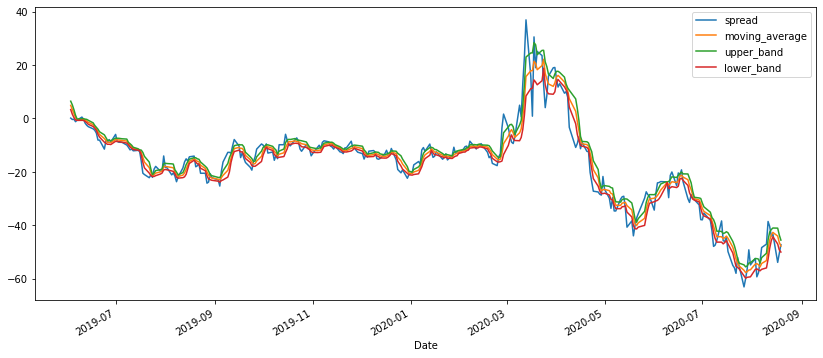

In [11]:
df[['spread','moving_average','upper_band','lower_band']][950:].plot(figsize=(14,6))

## Consolidate positions

positions_long and positions_short columns is initialized with NaN values using np.nan. 1 is assigned to positions_long when long_entry is True and 0 when long_exit is True. Similarly, -1 and 0 are assigned to positions_short.

Then, the positions_long and positions_short are consolidated and stored in positions.

In [12]:
df['positions_long'] = np.nan  
df.loc[df.long_entry,'positions_long']= 1  
df.loc[df.long_exit,'positions_long']= 0  
  
df['positions_short'] = np.nan  
df.loc[df.short_entry,'positions_short']= -1  
df.loc[df.short_exit,'positions_short']= 0  

# Fill NaN values
df = df.fillna(method='ffill')  

# Consolidate the positions
df['positions'] = df.positions_long + df.positions_short

df.head(7)

,GDX,GLD,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit,positions_long,positions_short,positions
Date,,,,,,,,,,,,,,
2015-08-21,14.908216,111.129997,27.695732,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN
2015-08-24,13.687658,110.529999,33.926623,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN
2015-08-25,13.242060,109.160004,35.050433,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN
2015-08-26,12.631783,107.669998,36.975861,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN
2015-08-27,13.358303,107.730003,32.969873,33.323704,3.481473,35.064441,31.582968,False,False,False,True,NaN,0.0,NaN
2015-08-28,13.803904,108.699997,31.446051,34.073768,2.092914,35.120225,33.027311,True,False,False,True,1.0,0.0,1.0
2015-08-31,13.668286,108.820000,32.325039,33.753452,2.238556,34.872730,32.634173,True,False,False,True,1.0,0.0,1.0


## Calculate daily returns

Difference of spread is calculated by subtracting yesterday's spread from today's spread. Next, daily returns are calculated by dividing the spread difference with previous day total portfolio value. 

In [13]:
# Calculate spread difference
df['spread_diff'] = df.spread - df.spread.shift(1)

# Calculate portfolio value
df['portfolio_value'] = df.GLD + abs(model.params[0]) * df.GDX

# Calculate daily returns
df['daily_returns'] = df.spread_diff / df.portfolio_value.shift(1)

## Cumulative strategy returns

Strategy returns are calculated by multiplying previous day position (long or short) with daily returns. Finally, cumulative strategy returns are calculated using cumprod() function.

In [14]:
# Calculate strategy returns
df['strategy_returns'] = df.positions.shift(1) * df.daily_returns

# Calculate cumulative strategy returns
df['cumret'] = (df.strategy_returns+1).cumprod()

### Plot cumulative strategy returns

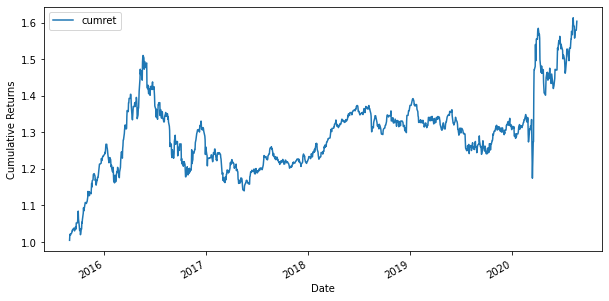

In [15]:
df.cumret.plot(figsize=(10,5))  
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.legend()  
plt.show()

In [16]:
df['cumret']

Date
2015-08-21         NaN
2015-08-24         NaN
2015-08-25         NaN
2015-08-26         NaN
2015-08-27         NaN
                ...   
2020-08-13    1.579036
2020-08-14    1.579036
2020-08-17    1.579036
2020-08-18    1.591460
2020-08-19    1.603740
Name: cumret, Length: 1258, dtype: float64

In [17]:
(df[['GLD','GDX']].pct_change()+1).cumprod()

,GLD,GDX
Date,,
2015-08-21,NaN,NaN
2015-08-24,0.994601,0.918128
2015-08-25,0.982273,0.888239
2015-08-26,0.968865,0.847303
2015-08-27,0.969405,0.896036
...,...,...
2020-08-13,1.649690,2.725343
2020-08-14,1.642581,2.706561
2020-08-17,1.678215,2.881632


## Remarks
Checking this strategy with the buy and hold strategy, we see that we did not outperform. This is likely due to the case that the hedge ratio estimation is poor and has been getting smaller. We need a dynamical way to estimate the hedge ratio. We can run a rolling window for 10 years data to run the linear regression and test if this strategy works We also have to analyze what happened to the gold industry. They performed poorly in the early 2010s making this spread smaller. In short, we would say they lose conintegration from time to time. We continue below to see if we can improve this strategy

# Improvements -Triplets
We notice that the conintegration broke down between gold. This is beacuse oil prices went up and the market crashed. We use a triplet to make a better mean reversion and more robus cointegrations
## Johansen Test
We start off by using the Johansen test. In the Johansen test, we check whether lambda has a zero eigenvalue. When all the eigenvalues are zero, that would mean that the series are not cointegrated, whereas when some of the eigenvalues contain negative values, it would imply that a linear combination of the time series can be created, which would result in stationarity.

In [30]:
# For checking cointegration
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import warnings
warnings.filterwarnings('ignore')

In [19]:
data = yf.download(['GDX','GLD','USO'], start, end, interval)
data

[*********************100%***********************]  3 of 3 completed


Adj Close                              Close              \
                  GDX         GLD         USO        GDX         GLD   
Date                                                                   
2015-08-21  14.908216  111.129997  105.839996  15.390000  111.129997   
2015-08-24  13.687658  110.529999   99.919998  14.130000  110.529999   
2015-08-25  13.242060  109.160004  101.839996  13.670000  109.160004   
2015-08-26  12.631783  107.669998  102.160004  13.040000  107.669998   
2015-08-27  13.358303  107.730003  111.599998  13.790000  107.730003   
...               ...         ...         ...        ...         ...   
2020-08-13  40.630001  183.330002   30.400000  40.630001  183.330002   
2020-08-14  40.349998  182.539993   30.330000  40.349998  182.539993   
2020-08-17  42.959999  186.500000   30.770000  42.959999  186.500000   
2020-08-18  42.660000  188.179993   30.600000  42.660000  188.179993   
2020-08-19  41.009998  182.240005   30.660000  41.009998  182.240005   

                       Dividends               High  ...         Low  \
                   USO       GDX GLD USO        GDX  ...         USO   
Date                                                 ...               
2015-08-21  105.839996       0.0   0   0  16.160000  ...  104.480003   
2015-08-24   99.919998       0.0   0   0  15.610000  ...   98.959999   
2015-08-25  101.839996       0.0   0   0  14.530000  ...  101.680000   
2015-08-26  102.160004       0.0   0   0  13.490000  ...  100.959999   
2015-08-27  111.599998       0.0   0   0  13.910000  ...  104.320000   
...                ...       ...  ..  ..        ...  ...         ...   
2020-08-13   30.400000       0.0   0   0  41.029999  ...   30.260000   
2020-08-14   30.330000       0.0   0   0  40.720001  ...   30.020000   
2020-08-17   30.770000       0.0   0   0  43.000000  ...   30.219999   
2020-08-18   30.600000       0.0   0   0  44.090000  ...   30.389999   
2020-08-19   30.660000       0.0   0   0  42.610001  ...   30.410000   

                 Open                         Stock Splits           \
                  GDX         GLD         USO          GDX GLD  USO   
Date                                                                  
2015-08-21  16.139999  110.930000  107.680000            0   0  0.0   
2015-08-24  15.160000  111.540001  100.959999            0   0  0.0   
2015-08-25  14.520000  110.010002  104.160004            0   0  0.0   
2015-08-26  13.480000  107.720001  102.800003            0   0  0.0   
2015-08-27  13.100000  107.330002  104.400002            0   0  0.0   
...               ...         ...         ...          ...  ..  ...   
2020-08-13  40.029999  181.559998   30.480000            0   0  0.0   
2020-08-14  40.459999  183.440002   30.230000            0   0  0.0   
2020-08-17  42.119999  184.690002   30.240000            0   0  0.0   
2020-08-18  44.070000  189.179993   30.410000            0   0  0.0   
2020-08-19  42.259998  187.210007   30.590000            0   0  0.0   

               Volume                     
                  GDX       GLD      USO  
Date                                      
2015-08-21   84174900  13917600  3927400  
2015-08-24  131865300  18388700  6165100  
2015-08-25   72336000   9974200  4038200  
2015-08-26   97910100  10856600  4055000  
2015-08-27  111023300   8102100  7021300  
...               ...       ...      ...  
2020-08-13   36092700  18596800  3414100  
2020-08-14   21075500  11792000  3792900  
2020-08-17   35736000  15709800  4307900  
2020-08-18   28185900  16291600  5589500  
2020-08-19   36848400  24575300  3776300  

[1258 rows x 24 columns]

In [20]:
df = data['Adj Close']

<AxesSubplot:xlabel='Date'>

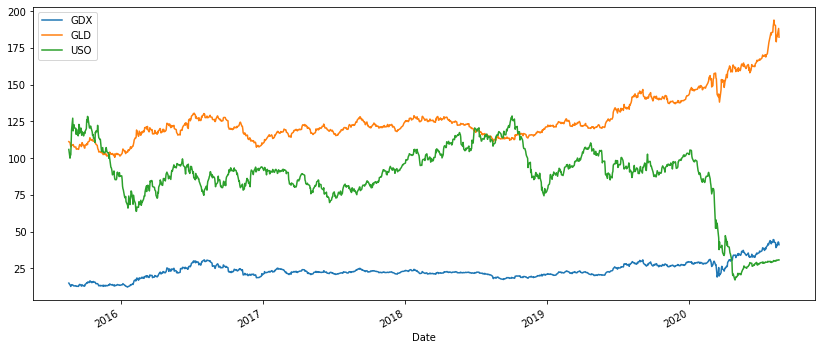

In [22]:
df.plot(figsize=(14,6))

In [31]:
# Run Johansen test on the whole dataset

# Store the results of Johansen test
result = coint_johansen(df, 0, 1)

# Print trace statistics and eigen statistics
print ('--------------------------------------------------')
print ('--> Trace Statistics')
print ('variable statistic Crit-90% Crit-95%  Crit-99%')
for i in range(len(result.lr1)):
    print ("r <= " + str(i), round(result.lr1[i], 4), round(result.cvt[i, 0],4), round(result.cvt[i, 1],4), round(result.cvt[i, 2],4))
print ('--------------------------------------------------')
print ('--> Eigen Statistics')
print ('variable statistic Crit-90% Crit-95%  Crit-99%')
for i in range(len(result.lr2)):
    print ("r <= " + str(i), round(result.lr2[i], 4), round(result.cvm[i, 0],4), round(result.cvm[i, 1],4), round(result.cvm[i, 2],4))

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r <= 0 31.1359 27.0669 29.7961 35.4628
r <= 1 10.6356 13.4294 15.4943 19.9349
r <= 2 2.1581 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r <= 0 20.5003 18.8928 21.1314 25.865
r <= 1 8.4775 12.2971 14.2639 18.52
r <= 2 2.1581 2.7055 3.8415 6.6349


We see that in the r <= case we have the test statistics greater than the 95% levels which means we have nonzero eigenvalue. Similary the eigen statistics for r<=0 can be rejected on the 90% levels. So it is a weaker coinitegration, but it still shows a positive test.

## Calculate Spread

We run the Johansen test on the first 90 days of data to avoid look-ahead bias. We form the spread using that and use that spread to take the positions. 

In [32]:
# Store the results of Johansen test
result = coint_johansen(df[:90], 0, 1)

# Store the value of eigenvector. Using this eigenvector, you can create the spread
ev = result.evec

# Take the transpose and use the first row of eigenvectors as it forms strongest cointegrating spread 
ev = result.evec.T[0]

# Normalise the eigenvectors by dividing the row with the first value of eigenvector
ev = ev/ev[0]

# Print the mean reverting spread
print("\nSpread = {}.GLD + ({}).GDX + ({}).USO".format(ev[0], ev[1], ev[2]))


Spread = 1.0.GLD + (-0.5548593777688613).GDX + (0.11373345623272149).USO


Based on the first 90 days, we should build the spread with the strongest eigenvectors which resulted in this linear combindation.

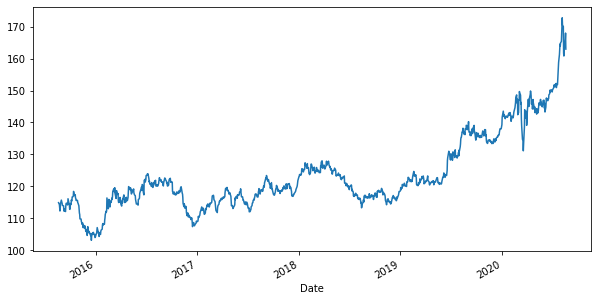

In [34]:
df['spread'] = df.GLD*ev[0] + df.GDX*ev[1] + df.USO*ev[2]
df.spread.plot(figsize=(10, 5))
plt.show()

## Calculate upper and lower band

The upper band is +0.5 * standard deviations above the moving average and the lower band is -0.5 * standard deviation below the moving average.

In [41]:
lookback = 5

# Moving Average and Moving Standard Deviation
df['moving_average'] = df.spread.rolling(lookback).mean()
df['moving_std_dev'] = df.spread.rolling(lookback).std()

# Upper band and lower band
df['upper_band'] = df.moving_average + 0.5*df.moving_std_dev
df['lower_band'] = df.moving_average - 0.5*df.moving_std_dev

## Take long and short positions

### Long entry and long exit

Long_entry is set to True value whenever the price falls below the lower band and False otherwise.

Long_exit is set to True value whenever the prices mean-reverts to the current moving average (prices >= moving average) and False otherwise.

In [42]:
df['long_entry'] = df.spread < df.lower_band
df['long_exit'] = df.spread >= df.moving_average

### Short entry and short exit

Short entry is set to True value whenever the price rises above the upper band and False otherwise.

Short exit is set to True value whenever the prices mean-reverts to the current moving average (prices <= moving average) and False otherwise.

In [43]:
df['short_entry'] = df.spread > df.upper_band
df['short_exit'] = df.spread <= df.moving_average

### Long positions and short positions
positions_long and positions_short columns is initialized with NaN values using np.nan. 1 is assigned to positions_long when long_entry is True and 0 when long_exit is True. Similarly, -1 and 0 are assigned to positions_short.

In [44]:
df['positions_long'] = np.nan
df.loc[df.long_entry, 'positions_long'] = 1
df.loc[df.long_exit, 'positions_long'] = 0

df['positions_short'] = np.nan
df.loc[df.short_entry, 'positions_short'] = -1
df.loc[df.short_exit, 'positions_short'] = 0

# Fill NaN values
df = df.fillna(method='ffill')

# Consolidate the positions
df['positions'] = df.positions_long + df.positions_short

## Calculate daily returns

In [45]:
# Calculate spread difference
df['spread_diff'] = df.spread-df.spread.shift(1)

# Calculate portfolio value
df['portfolio_value'] = abs(ev[0])*df.GLD + abs(ev[1])*df.GDX + abs(ev[2])*df.USO

# Calculate daily returns
df['daily_returns'] = df.spread_diff /df['portfolio_value'] .shift(1)

## Calculate cumulative strategy returns

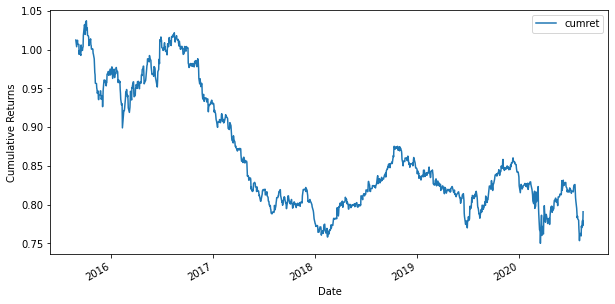

In [46]:
# Calculate strategy returns
df['strategy_returns'] = df.daily_returns  * df.positions.shift(1)

df = df.dropna()

# Calculate cumulative strategy returns
df['cumret'] = ((df.strategy_returns+1)).cumprod()

df.cumret.plot(figsize=(10,5))  
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.legend()  
plt.show()

## Remark
Again, we see that this strategy did not perform as well, especially when the gold miners has been growing at an extreme rate and we shorted them.  In additon, oil prices has been getting much weaker in the few recent years. At the same time, our spread went up and isn't stationary. Overall, there is good insights to be gained from viewing this.

#### Notes:

Stocks- highly correlated can still performed well.
ETFS - don't easily lose cointegration
Currency- High liquity and no short constraints
Futures-has a big differences in time and could lose coinitegrations.

A more common cointegrations is index selecting the top stocks in that basics. Thus, the profits are smalle in those. However, we can use a smaller set of the index 